## Modelo Small VGGNet

In [1]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense

def SmallVGGNet(inputShape):
    chanDim = -1
    model = Sequential()
 
    # CONV => RELU => POOL
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(3))
    model.add(Activation('softmax'))

    return model

## Inicializacion entrenamiento

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

IMAGE_DIMS = (96, 96, 3)

## Carga de Imagenes

In [3]:
imgPaths = []

for (root,dirs,files) in os.walk('dataset2', topdown=True): 
     if len(dirs) == 0:
        for name in files:
            if 'DS' in name:
                continue
            imgPaths.append(root+'/'+name)
            #print (root) 
            #print (dirs) 
            #print (files) 
            
print(imgPaths[0])

dataset2/shirts/blue-305.jpg


In [4]:
data = []
labels = []

for imgPath in imgPaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imgPath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract set of class labels from the image path and update the
    # labels list
    label = imgPath.split('/')[-2]
    labels.append(label)

# Normalizing image
data = np.array(data, dtype='float')/255    
labels = np.array(labels)

## Label encoding

In [5]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)
Y = le.transform(labels)

Y = to_categorical(Y,num_classes=3)

In [56]:
le.classes_

array(['dresses', 'jeans', 'shirts'], dtype='<U7')

## Spliting Data

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data,Y, test_size=0.3, stratify=Y, random_state=123)

In [7]:
aug = ImageDataGenerator(width_shift_range=0.1,
                        height_shift_range=0.1, 
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode="nearest")

In [8]:
EPOCHS = 30 #40
INIT_LR = 0.001
BS = 16

model = SmallVGGNet(IMAGE_DIMS)

opt = Adam(lr=INIT_LR)

model.compile(loss='categorical_crossentropy',
             optimizer = opt,
             metrics=['accuracy'])

H = model.fit(
        x=aug.flow(trainX, trainY, batch_size=BS), 
        validation_data=(testX, testY),
        steps_per_epoch=len(trainX) // BS,
        epochs=EPOCHS, verbose=1)

Epoch 1/30
94/94 [==============================] - 21s 212ms/step - loss: 1.0721 - accuracy: 0.6324 - val_loss: 1.2230 - val_accuracy: 0.3641
Epoch 2/30
94/94 [==============================] - 29s 313ms/step - loss: 0.4748 - accuracy: 0.8319 - val_loss: 1.7263 - val_accuracy: 0.3533
Epoch 3/30
94/94 [==============================] - 29s 303ms/step - loss: 0.3844 - accuracy: 0.8713 - val_loss: 0.8722 - val_accuracy: 0.5284
Epoch 4/30
94/94 [==============================] - 26s 274ms/step - loss: 0.3842 - accuracy: 0.8665 - val_loss: 0.7549 - val_accuracy: 0.7051
Epoch 5/30
94/94 [==============================] - 22s 233ms/step - loss: 0.3218 - accuracy: 0.8999 - val_loss: 0.5023 - val_accuracy: 0.8218
Epoch 6/30
94/94 [==============================] - 24s 257ms/step - loss: 0.3231 - accuracy: 0.9126 - val_loss: 0.2848 - val_accuracy: 0.9048
Epoch 7/30
94/94 [==============================] - 23s 242ms/step - loss: 0.2660 - accuracy: 0.9124 - val_loss: 0.2299 - val_accuracy: 0.9263

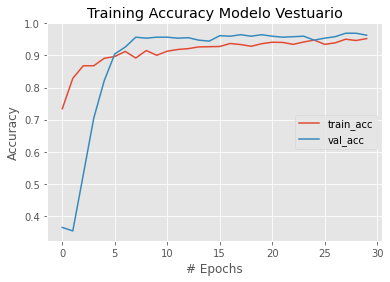

In [30]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
#plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy Modelo Vestuario")
plt.xlabel("# Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="center right")
plt.savefig('train-test-plot.png')

In [48]:
from sklearn.metrics import classification_report

predictions= model.predict(testX,batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1),target_names=['Vestidos','Jeans','Poleras']))

              precision    recall  f1-score   support

    Vestidos       0.95      0.98      0.96       230
       Jeans       0.99      0.97      0.98       210
     Poleras       0.96      0.94      0.95       211

    accuracy                           0.96       651
   macro avg       0.96      0.96      0.96       651
weighted avg       0.96      0.96      0.96       651



In [11]:
model.save('model-v2.hdf5', save_format="hdf5")

In [43]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
activation_56 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_57 (Activation)   (None, 32, 32, 64)       

In [19]:
%pwd

'/Users/nicolas/projectos-falabella/Falabella-talk'

# Out of the box Model Testing

In [64]:
import cv2
from keras.preprocessing.image import img_to_array
from keras.models import load_model

model = load_model('model-v2.h5')

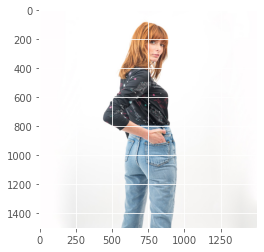

In [57]:
img = cv2.imread('polera-jeans.jpg')

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [58]:
img = cv2.resize(img,(96,96))
img = img.astype("float") / 255.0
img = np.array(img)
img = np.expand_dims(img, axis=0)
model.predict(img)

array([[9.9960297e-01, 2.2684591e-04, 1.7012998e-04]], dtype=float32)